# Load data

In [46]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import ast

sns.set_theme(style="whitegrid")

# load results.csv
df = pd.read_csv("results.csv")

# convert strings to lists
df["position_gt"] = df["position_gt"].apply(ast.literal_eval)
df["position_contact_detector"] = df["position_contact_detector"].apply(ast.literal_eval)

# Sort data by distance between ground truth and contact detector

In [47]:
# sort by norm(gt,contact detector) in descending order
df = df.sort_values("norm(gt,contact detector)", ascending=False)
df

,subject_root,label,prefix,contact,position_gt,position_contact_detector,"norm(gt,contact detector)"
3891,1673284,H8,H,8,"[5.22233796380543, 9.08716546174831, 122.96873...","[5.8827018842567895, 9.727863300815898, 122.43...",1.065802
3890,1673284,H7,H,7,"[3.26531036241732, 9.19969472730752, 120.06202...","[3.798486988966772, 9.20925031335787, 119.6655...",0.664480
8820,2116101,I18,I,18,"[57.8495758941266, 31.0184708242033, 24.082278...","[58.209854497786694, 31.153391848821457, 23.59...",0.619458
8996,2126753,F10,F,10,"[-59.9269859161135, 10.8673825701746, 28.44600...","[-60.22799712750981, 10.564648436167431, 28.02...",0.602017
6342,1923351,E13,E,13,"[-24.8079327300014, -0.311869253372777, 49.070...","[-24.790782933725154, -0.4869190927634577, 49....",0.501986
...,...,...,...,...,...,...,...
3532,1637126,M5,M,5,"[29.1408710899824, -23.2958755982069, 8.287679...","[29.13957022249261, -23.299918167509617, 8.288...",0.004374
10219,2194610,D4,D,4,"[25.4868093218496, -43.4253967861413, 26.60134...","[25.490547146645852, -43.4246219162973, 26.600...",0.004035
6904,1957425,N6,N,6,"[12.8130061240272, 43.2715527940539, 36.413243...","[12.811138100248456, 43.2728514044756, 36.4107...",0.003359
14127,65639,B4,B,4,"[27.0612051240914, -21.6166899228658, -12.2442...","[27.063147708839722, -21.616611019220045, -12....",0.002948


# Plot of max and mean norm for each electrode

(0.0, 1.2)

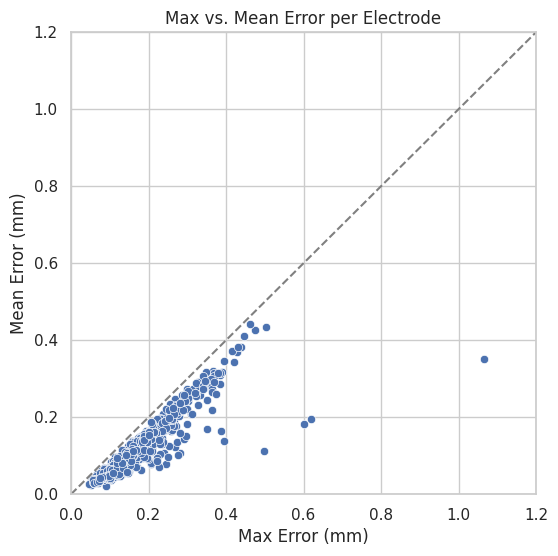

In [48]:
# group by subject and prefix
electrodes = df.groupby(["subject_root", "prefix"])["norm(gt,contact detector)"].agg(["max", "mean"]).reset_index()

plt.figure(figsize=(6, 6))

# plot grouped XY plot of max norm(gt,contact detector) for each subject
ax = sns.scatterplot(
    data=electrodes,
    x="max",
    y="mean",
)

plt.title("Max vs. Mean Error per Electrode")
plt.xlabel("Max Error (mm)")
plt.ylabel("Mean Error (mm)")

plt.plot([0, 2], [0, 2], ls="--", c="gray", label="Mean = Max limit")

plt.xlim(0, 1.2)
plt.ylim(0, 1.2)

# Plot of max and mean norm for each subject

Text(0, 0.5, 'Mean Error (mm)')

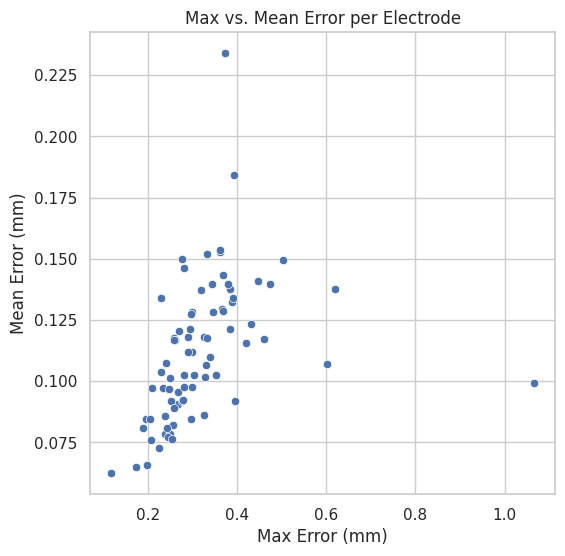

In [49]:
# group by subject
electrodes = df.groupby(["subject_root"])["norm(gt,contact detector)"].agg(["max", "mean"]).reset_index()

plt.figure(figsize=(6, 6))

# plot grouped XY plot of max norm(gt,contact detector) for each subject
ax = sns.scatterplot(
    data=electrodes,
    x="max",
    y="mean",
)

plt.title("Max vs. Mean Error per Electrode")
plt.xlabel("Max Error (mm)")
plt.ylabel("Mean Error (mm)")

# Histogram of norm(gt,contact detector)

Text(0, 0.5, 'Number of Contacts (-)')

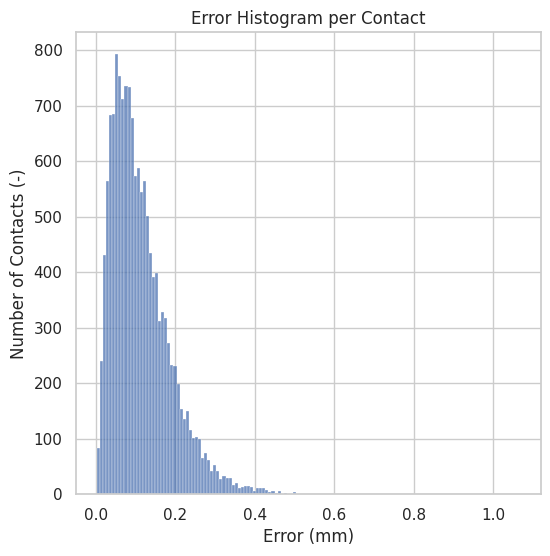

In [50]:
# plot histogram of norm(gt,contact detector) for each subject
plt.figure(figsize=(6, 6))

sns.histplot(data=df, x="norm(gt,contact detector)")

plt.title("Error Histogram per Contact")
plt.xlabel("Error (mm)")
plt.ylabel("Number of Contacts (-)")

# ECDF of norm(gt,contact detector)

Text(0, 0.5, 'Proportion (-)')

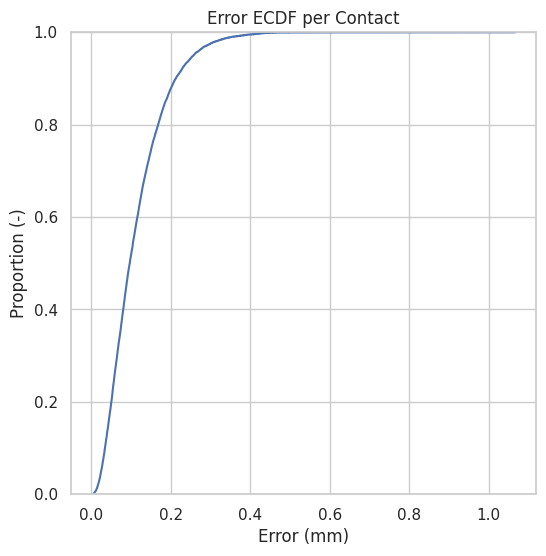

In [51]:
plt.figure(figsize=(6, 6))

sns.ecdfplot(data=df, x="norm(gt,contact detector)")

plt.title("Error ECDF per Contact")
plt.xlabel("Error (mm)")
plt.ylabel("Proportion (-)")

# Descriptive statistics

In [52]:
print(f"p95: {df['norm(gt,contact detector)'].quantile(0.95)}")
print(f"p99: {df['norm(gt,contact detector)'].quantile(0.99)}")
print(f"q1: {df['norm(gt,contact detector)'].quantile(0.25)}")
print(f"q3: {df['norm(gt,contact detector)'].quantile(0.75)}")
print(f"median: {df['norm(gt,contact detector)'].median()}")

p95: 0.2572619675997506
p99: 0.3534113006639826
q1: 0.05761197318728487
q3: 0.1515699396927033
median: 0.0968237623820386


# Bland-Altman plot


## Support functions

In [53]:
def normalize(v: np.ndarray) -> np.ndarray:
    norm = np.linalg.norm(v)
    return v if norm == 0 else v / norm

def draw_ba_lines(data: pd.Series, **kwargs) -> None:
    if len(data) == 0: return
    
    # calculate bias and standard deviation
    md = data.mean()
    sd = data.std()
    
    ax = plt.gca()

    # draw lines
    ax.axhline(md, color='red', linestyle='-', linewidth=1.5, label='Bias')
    ax.axhline(md + 1.96*sd, color='gray', linestyle='--', linewidth=1)
    ax.axhline(md - 1.96*sd, color='gray', linestyle='--', linewidth=1)
    ax.axhline(0, color='black', linewidth=0.5, alpha=0.5)
    
    # add text
    trans = ax.get_yaxis_transform()
    ax.text(0.05, md, f'Bias: {md:.3f}', color='red', transform=trans, ha='left', va='bottom', fontsize=9, fontweight='bold')
    ax.text(0.95, md + 1.96*sd, f'+1.96SD: {md + 1.96*sd:.3f}', color='gray', transform=trans, ha='right', va='bottom', fontsize=8)
    ax.text(0.95, md - 1.96*sd, f'-1.96SD: {md - 1.96*sd:.3f}', color='gray', transform=trans, ha='right', va='top', fontsize=8)

## Positions in the RAS

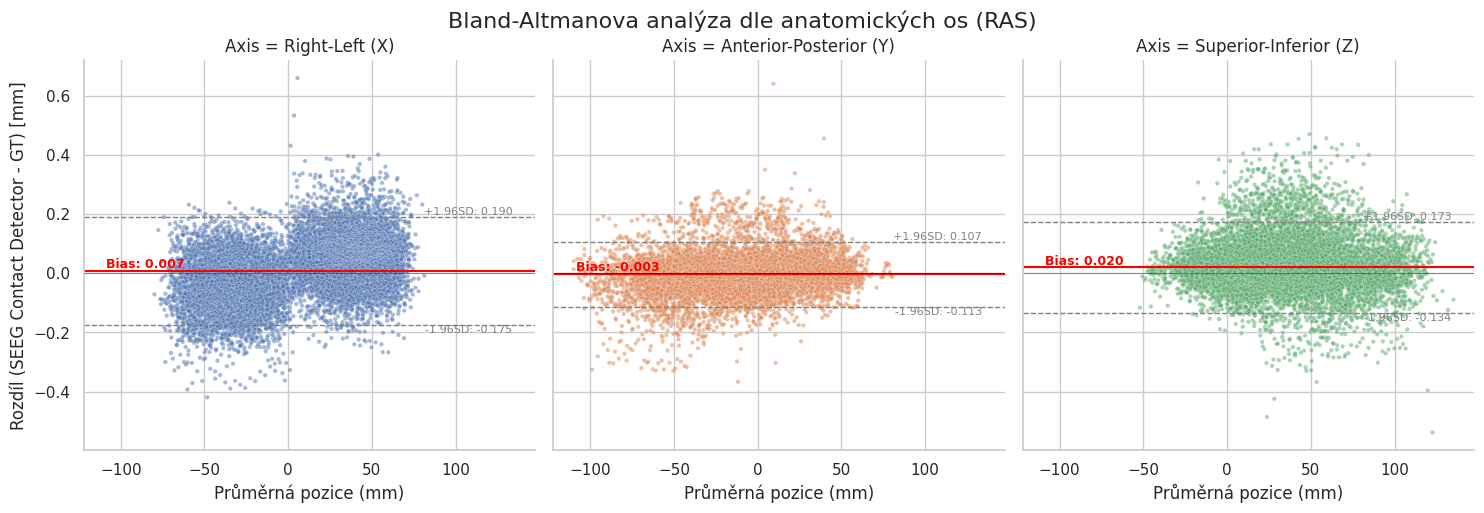

In [54]:
cols = ['Right-Left (X)', 'Anterior-Posterior (Y)', 'Superior-Inferior (Z)']
gt = pd.DataFrame(df["position_gt"].tolist(), columns=cols)
det = pd.DataFrame(df["position_contact_detector"].tolist(), columns=cols)

ba_data = []
for col in cols:
    diff = det[col] - gt[col]
    mean = (det[col] + gt[col]) / 2
    
    temp_df = pd.DataFrame({
        'Mean_Position': mean,
        'Difference': diff,
        'Axis': col
    })
    ba_data.append(temp_df)

df_ba = pd.concat(ba_data, ignore_index=True)

g = sns.relplot(
    data=df_ba,
    x="Mean_Position", 
    y="Difference",
    col="Axis",
    hue="Axis",
    s=10,
    alpha=0.5,
    legend=False
)

g.map(draw_ba_lines, "Difference")

g.set_axis_labels("Průměrná pozice (mm)", "Rozdíl (SEEG Contact Detector - GT) [mm]")
g.figure.suptitle("Bland-Altmanova analýza dle anatomických os (RAS)", y=1.02, fontsize=16)

plt.show()

## Support functions

In [55]:
def rotate_to_gt_shaft(group):
    group = group.sort_values("contact")
    
    coords_gt = np.vstack(group['position_gt'].values)
    p_tip_gt = coords_gt[0]
    p_entry_gt = coords_gt[-1]
    
    vec_shaft = p_entry_gt - p_tip_gt
    u_x = normalize(vec_shaft) # new X-axis
    
    # use global Z as helper
    # if shaft is vertical (parallel to Z), use global Y as helper
    global_ref = np.array([0, 0, 1])
    if np.abs(np.dot(u_x, global_ref)) > 0.99: 
        global_ref = np.array([0, 1, 0])

    u_y = normalize(np.cross(u_x, global_ref)) # new Y-axis
    u_z = normalize(np.cross(u_x, u_y)) # new Z-axis (perpendicular to both X and Y)
    R = np.array([u_x, u_y, u_z]) # rotation matrix
    
    # transform predicted points
    coords_det = np.vstack(group['position_contact_detector'].values)
    det_centered = coords_det - p_tip_gt  # translate relative to GT Tip
    det_rotated = (R @ det_centered.T).T  # rotate
    
    # transform ground truth points
    gt_centered = coords_gt - p_tip_gt    # translate relative to GT Tip
    gt_rotated = (R @ gt_centered.T).T    # rotate
    
    # create dataframe
    return pd.DataFrame({
        "position_gt": gt_rotated.tolist(),
        "position_contact_detector": det_rotated.tolist(),
        "mean_depth": (det_rotated[:, 0] + gt_rotated[:, 0]) / 2
    })

normalized_data = df.groupby(["subject_root", "prefix"]).apply(rotate_to_gt_shaft).reset_index()

/tmp/ipykernel_1945434/3852634078.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_data = df.groupby(["subject_root", "prefix"]).apply(rotate_to_gt_shaft).reset_index()


## Deviations from GT shaft

(-2.0, 2.0)

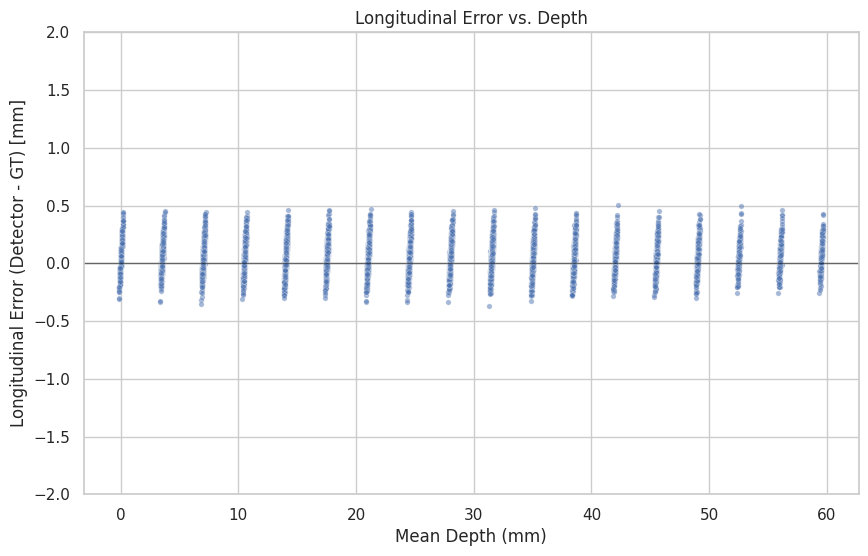

In [56]:
gt_matrix = np.vstack(normalized_data['position_gt'].values)
det_matrix = np.vstack(normalized_data['position_contact_detector'].values)

normalized_data['error_x'] = det_matrix[:, 0] - gt_matrix[:, 0]

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=normalized_data,
    x="mean_depth",
    y="error_x",
    alpha=0.5,
    s=15
)

plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

plt.title("Longitudinal Error vs. Depth")
plt.xlabel("Mean Depth (mm)")
plt.ylabel("Longitudinal Error (Detector - GT) [mm]")

plt.ylim(-2, 2)

(-0.1, 1.2)

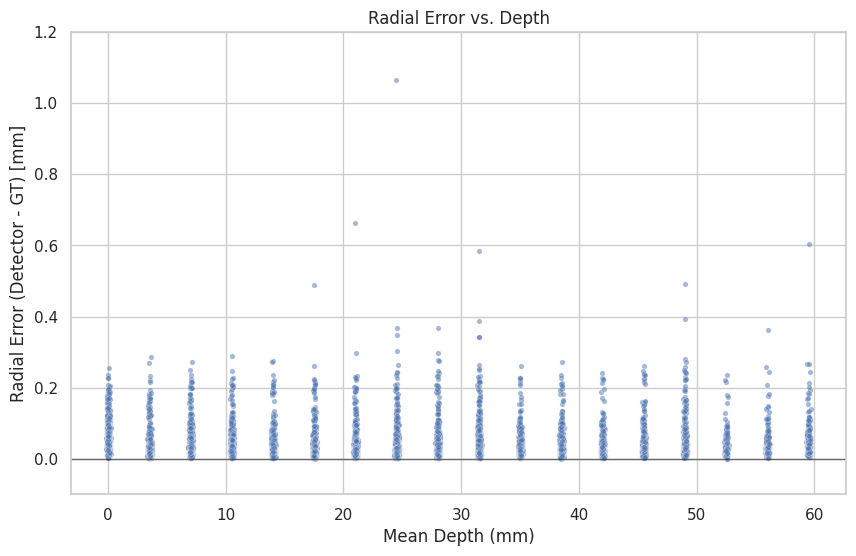

In [57]:
y_dev = det_matrix[:, 1] - gt_matrix[:, 1]
z_dev = det_matrix[:, 2] - gt_matrix[:, 2]

normalized_data['error_radial'] = np.sqrt(y_dev**2 + z_dev**2)

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=normalized_data,
    x="mean_depth",
    y="error_radial",
    alpha=0.5,
    s=15
)

plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

plt.title("Radial Error vs. Depth")
plt.xlabel("Mean Depth (mm)")
plt.ylabel("Radial Error (Detector - GT) [mm]")

plt.ylim(-0.1, 1.2)

(0.0, 1.2)

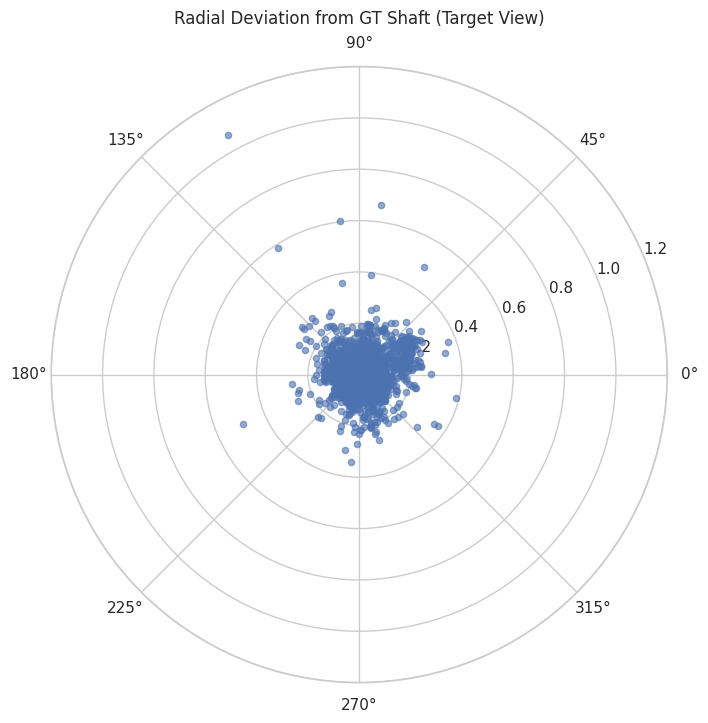

In [58]:
r = np.sqrt(y_dev**2 + z_dev**2)
theta = np.arctan2(z_dev, y_dev)

normalized_data['polar_r'] = r
normalized_data['polar_theta'] = theta

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')

# Create the scatter plot
sc = ax.scatter(
    normalized_data['polar_theta'],  # Angle
    normalized_data['polar_r'],      # Radius (Error magnitude)
    alpha=0.6,
    s=20
)

ax.set_title("Radial Deviation from GT Shaft (Target View)", va='bottom')
# ax.set_rlabel_position(45)  # Move radial labels out of the way

# Set a limit for the radius if you want to zoom in on the error (e.g., 2mm max error)
ax.set_ylim(0, 1.2)

# Deviations of detected contacts from the linear approximation

In [59]:
import sklearn
def calculate_trajectory(group):
    group = group.sort_values("contact")
    coords = np.vstack(group['position_contact_detector'].values)

    t = np.arange(len(coords)).reshape(-1, 1)
    
    model = sklearn.linear_model.LinearRegression().fit(t, coords)
    points_on_ideal_line = model.predict(t)
    
    deviations = np.linalg.norm(coords - points_on_ideal_line, axis=1)

    return pd.DataFrame({
        "label": group["label"],
        "deviation": deviations
    })

traj_data = df.groupby(["subject_root", "prefix"]).apply(calculate_trajectory).reset_index()
traj_data = traj_data.sort_values("deviation", ascending=False)
traj_data

/tmp/ipykernel_1945434/39252383.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  traj_data = df.groupby(["subject_root", "prefix"]).apply(calculate_trajectory).reset_index()


,subject_root,prefix,level_2,label,deviation
3543,1673284,M,3948,M15,1.125933
5909,1883612/i3,J,6134,J1,0.996331
5746,1883612/i2,J,5963,J18,0.962041
9055,2126753,L,9047,L12,0.893494
5729,1883612/i2,J,5954,J1,0.887810
...,...,...,...,...,...
1743,1326593,T,2156,T6,0.002426
9510,2179801,E,9502,E10,0.002264
5040,1855440,M,5268,M3,0.002257
14450,890775,Xd,14459,Xd7,0.002149


/tmp/ipykernel_1945434/447375408.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


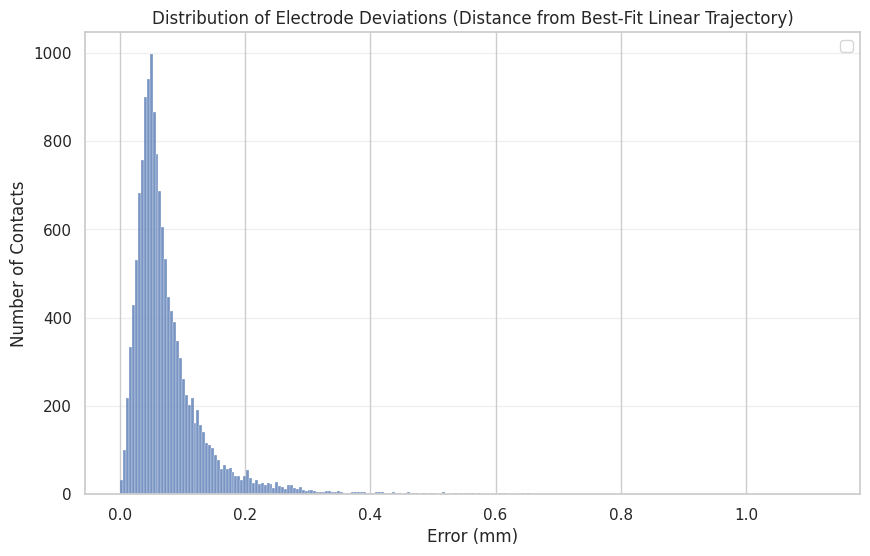

In [60]:
# Assuming 'traj_data' is the result from the previous step
plt.figure(figsize=(10, 6))

# Plot Histogram with Kernel Density Estimate (KDE)
sns.histplot(
    data=traj_data, 
    x="deviation", 
)

# Labels
plt.title("Distribution of Electrode Deviations (Distance from Best-Fit Linear Trajectory)")
plt.xlabel("Error (mm)")
plt.ylabel("Number of Contacts")
plt.legend()

plt.grid(axis='y', alpha=0.3)
plt.show()

# Electrode length check

In [61]:
def calculate_electrode_stats(group):
    group = group.sort_values("contact")
    coords_det = np.vstack(group['position_contact_detector'].values)
    coords_gt = np.vstack(group['position_gt'].values)
    
    diffs_det = np.diff(coords_det, axis=0)
    diffs_gt = np.diff(coords_gt, axis=0)
    
    segment_lengths_det = np.linalg.norm(diffs_det, axis=1)
    segment_lengths_gt = np.linalg.norm(diffs_gt, axis=1)
    
    det_length = np.sum(segment_lengths_det)
    gt_length = np.sum(segment_lengths_gt)
    
    real_length = (len(group) - 1) * 3.5 # 3.5mm spacing
    
    return pd.DataFrame({
        "real_length": [real_length],
        "det_length": [det_length],
        "gt_length": [gt_length]
    })

length_data = df.groupby(["subject_root", "prefix"]).apply(calculate_electrode_stats).reset_index()
length_data["error_length"] = length_data["det_length"] - length_data["gt_length"]
length_data.sort_values("error_length", ascending=True)

length_data["spec_minus_gt"] = length_data["real_length"] - length_data["gt_length"]
length_data["spec_minus_det"] = length_data["real_length"] - length_data["det_length"]
length_data

/tmp/ipykernel_1945434/1157387257.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  length_data = df.groupby(["subject_root", "prefix"]).apply(calculate_electrode_stats).reset_index()


,subject_root,prefix,level_2,real_length,det_length,gt_length,error_length,spec_minus_gt,spec_minus_det
0,104734,C,0,49.0,48.962754,48.996558,-0.033805,0.003442,0.037246
1,104734,G,0,31.5,31.531736,31.491058,0.040678,0.008942,-0.031736
2,104734,H,0,49.0,48.999245,49.036287,-0.037042,-0.036287,0.000755
3,104734,I,0,49.0,48.990061,49.030550,-0.040489,-0.030550,0.009939
4,104734,J,0,49.0,49.027427,49.014826,0.012601,-0.014826,-0.027427
...,...,...,...,...,...,...,...,...,...
1073,890775,Pd,0,49.0,48.953014,48.971052,-0.018038,0.028948,0.046986
1074,890775,Ps,0,38.5,38.479464,38.527763,-0.048300,-0.027763,0.020536
1075,890775,Qd,0,31.5,31.494225,31.481180,0.013045,0.018820,0.005775
1076,890775,Xd,0,59.5,59.543793,59.592246,-0.048453,-0.092246,-0.043793


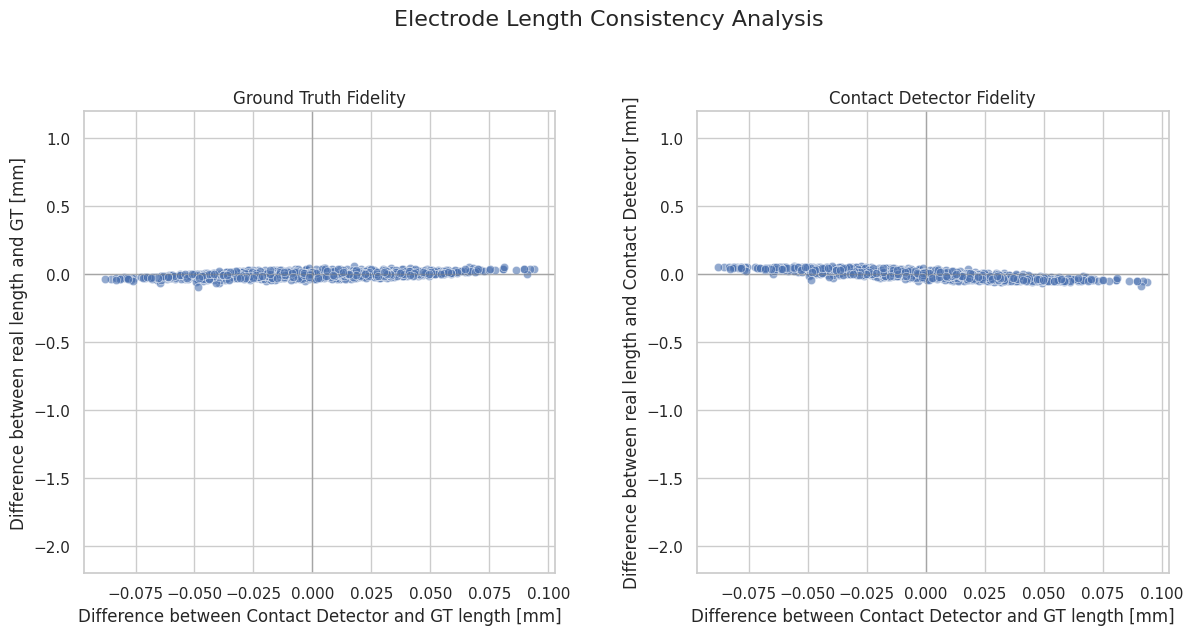

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

y_lim = (-2.2, 1.2)

sns.scatterplot(
    data=length_data, 
    x="error_length",
    y="spec_minus_gt",
    alpha=0.6,
    ax=ax[0]
)
# Add a zero line for reference
ax[0].axhline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
ax[0].axvline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)

ax[0].set_ylim(y_lim)

ax[0].set_title("Ground Truth Fidelity")
ax[0].set_xlabel("Difference between Contact Detector and GT length [mm]")
ax[0].set_ylabel("Difference between real length and GT [mm]")

sns.scatterplot(
    data=length_data, 
    x="error_length",
    y="spec_minus_det",
    alpha=0.6,
    ax=ax[1]
)
# Add a zero line for reference
ax[1].axhline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
ax[1].axvline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)

ax[1].set_ylim(y_lim)

ax[1].set_title("Contact Detector Fidelity")
ax[1].set_xlabel("Difference between Contact Detector and GT length [mm]")
ax[1].set_ylabel("Difference between real length and Contact Detector [mm]")

# Add a global title
plt.suptitle("Electrode Length Consistency Analysis", fontsize=16, y=1.05)
plt.subplots_adjust(wspace=0.3)

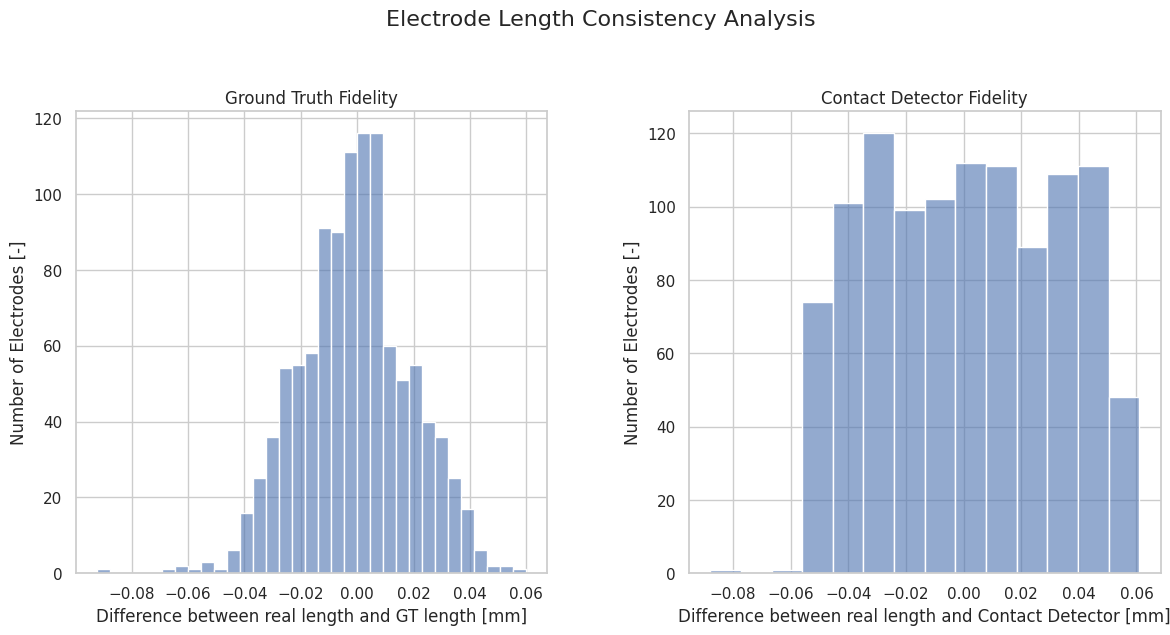

In [63]:
length_data["spec_minus_gt"] = length_data["real_length"] - length_data["gt_length"]
length_data["spec_minus_det"] = length_data["real_length"] - length_data["det_length"]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    data=length_data, 
    x="spec_minus_gt",
    alpha=0.6,
    ax=ax[0]
)

ax[0].set_title("Ground Truth Fidelity")
ax[0].set_xlabel("Difference between real length and GT length [mm]")
ax[0].set_ylabel("Number of Electrodes [-]")


sns.histplot(
    data=length_data, 
    x="spec_minus_det",
    alpha=0.6,
    ax=ax[1]
)

ax[1].set_title("Contact Detector Fidelity")
ax[1].set_xlabel("Difference between real length and Contact Detector [mm]")
ax[1].set_ylabel("Number of Electrodes [-]")

# Add a global title
plt.suptitle("Electrode Length Consistency Analysis", fontsize=16, y=1.05)
plt.subplots_adjust(wspace=0.3)